<a href="https://colab.research.google.com/github/Ibraheem101/mlops/blob/main/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Logistic Regression from scratch

In [1]:
import os
import json
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

In [2]:
SEED = 1234

In [3]:
np.random.seed(SEED)

In [4]:
from pandas.plotting import scatter_matrix

In [5]:
path = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tumors.csv"
df = pd.read_csv(path)
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,13.472969,15.250393,malignant
1,10.805510,14.109676,malignant
2,13.834053,15.793920,malignant
3,9.572811,17.873286,malignant
4,7.633667,16.598559,malignant


In [6]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle entire fraction of dataset

In [7]:
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [8]:
# Define X and y
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values

In [9]:
X

array([[15.3358602 , 14.63753513],
       [ 9.85753504, 14.51894245],
       [17.63257858, 15.86958513],
       ...,
       [21.96745871, 15.33273379],
       [10.53879647, 15.12725907],
       [11.42145881, 15.80375843]])

In [10]:
X[:,0]

array([15.3358602 ,  9.85753504, 17.63257858, 18.36917354, 14.50936702,
       13.97798684, 15.78171871, 10.73159504, 15.3612354 , 14.70363013,
       12.19443645, 14.37797558, 12.68718234, 14.52015972, 14.60457064,
       13.33068615, 13.8562568 , 14.43249799, 16.30819155, 12.31993955,
       18.43594498, 13.27736701, 15.32899819, 13.44035023, 13.17378324,
       19.11430292, 12.54870513, 16.12871213, 10.60075818, 14.40780972,
       17.8368257 , 18.69265151, 13.55618269, 18.01865938, 12.08328819,
       17.65713506, 11.10713159, 11.0586516 , 12.17324544, 15.67129607,
       13.25098172, 13.9305596 , 15.81950887, 14.63320316, 14.7220125 ,
       14.75362162, 18.75922484, 16.40937204, 19.64261251, 11.5066204 ,
       13.27570235, 10.4832406 , 13.65976147, 16.97473168, 13.920709  ,
       10.63463098, 15.23319717, 12.36695809, 20.21910162,  9.6725226 ,
       14.21293208, 11.78036504, 15.50816284, 18.05478005, 17.20774319,
       15.65537088, 19.55801353, 15.19405304, 11.35068553, 18.61

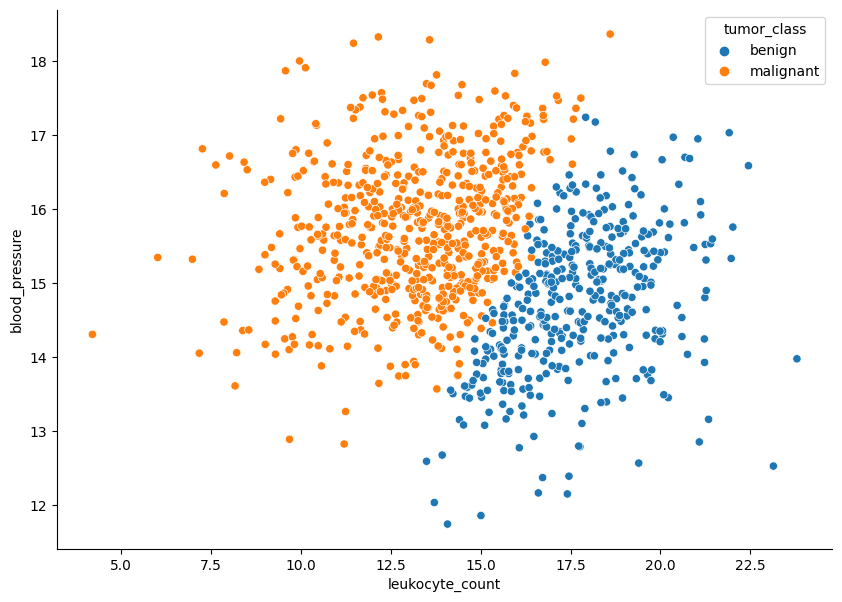

In [11]:
plt.figure(figsize = (10, 7))
sns.scatterplot(data = df, x = 'leukocyte_count', y = 'blood_pressure', hue = 'tumor_class')
sns.despine()

### Splitting

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [14]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


### Label Encoding
Create custom label encoding class instead of using scikit-learn's label encoder


In [16]:
class LabelEncoder(object):
  """
  Class to encode categorical data into numerical labels and decode the labels back to their original categories.

  Attributes:
      mapping (dict): A dictionary containing a mapping from each unique category to a numerical label.
      reverse_mapping (dict): A dictionary containing a mapping from each numerical label to its corresponding category.

  Methods:
      fit(data): Create a mapping from each unique category in the input data to a numerical label(value).
      transform(data): Convert a list of categorical values to numerical labels.
      reverse_transform(data): Convert a list of numerical labels to their original categorical values.

  """


  def __init__(self):
    self.mapping = {}
    self.reverse_mapping = {}
    self.classes = []


  def fit(self, data):
    # Get unique values in data
    unique_values = set(data)
    for value, label in enumerate(unique_values):
      self.mapping[label] = value
      self.reverse_mapping[value] = label
      self.classes.append(label)
    return self

  def transform(self, data):
    return [self.mapping[lab] for lab in data]

  def reverse_transform(self, data):
    return [self.reverse_mapping[val] for val in data]


In [17]:
# Test label encoder

labels = ['cat', 'dog', 'cat', 'bird', 'bird', 'dog']
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
print(encoded_labels)
print(encoder.reverse_transform(encoded_labels))

[0, 1, 0, 2, 2, 1]
['cat', 'dog', 'cat', 'bird', 'bird', 'dog']


In [18]:
for i, j in enumerate(['cat', 'dog', 'cat', 'bird', 'bird', 'dog']):
  print(i, j)

0 cat
1 dog
2 cat
3 bird
4 bird
5 dog


In [19]:
# Encode target data
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.mapping

{'benign': 0, 'malignant': 1}

In [20]:
y_train_enc = label_encoder.transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [21]:
# Test
print (f"y_train[0]: {y_train[0]}")
print (f"y_train_enc[0]: {y_train_enc[0]}")
print (f"decoded: {label_encoder.reverse_transform([y_train_enc[0]])}")

y_train[0]: malignant
y_train_enc[0]: 1
decoded: ['malignant']


In [22]:
# Calculate class weights
class_weights = {}
total_samples = len(y_train_enc)
num_classes = len(np.unique(y_train_enc))
class_samples = np.bincount(y_train_enc)
for i in range(num_classes):
    class_weights[i] = total_samples / (num_classes * class_samples[i])

print(f"Class weights: {class_weights}")

Class weights: {0: 1.286764705882353, 1: 0.8177570093457944}


In [23]:
total_samples

700

The purpose of calculating class weights is to address class imbalance in a machine learning model. Class imbalance refers to the situation where the number of examples in different classes is not equal. When there is class imbalance, the model may be biased towards the majority class, leading to poor performance on the minority class.

To address this, one approach is to assign higher weights to the minority class during training, so that the model pays more attention to it. This is done by calculating class weights based on the frequency of examples in each class. The formula used to calculate class weights is class_weight = total_samples / (num_classes * class_samples), where total_samples is the total number of examples, num_classes is the number of classes, and class_samples is the number of examples in each class.

### Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [26]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test_scaled[:, 0], axis=0):.1f}, std: {np.std(X_test_scaled[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test_scaled[:, 1], axis=0):.1f}, std: {np.std(X_test_scaled[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


### Intitalize Weights

In [27]:
X_train_scaled

array([[-0.024188  , -0.47932129],
       [-1.26316762, -1.14198851],
       [-0.97307243, -0.31201268],
       ...,
       [-1.19095592,  0.5474149 ],
       [ 1.02242646, -0.45692593],
       [ 1.47068792, -0.40498094]])

In [28]:
input_dim = X_train_scaled.shape[1]
input_dim

2

In [29]:
# Initialize random weights W and b
W = 0.01 * np.random.randn(input_dim, num_classes)
b = np.zeros((1, num_classes))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


In a softmax classifier, the logits are the outputs of the linear transformation of the input features (X) by the weight matrix (W), before applying the softmax function. In other words, logits are the raw, unnormalized scores that are produced by the model before converting them to probabilities. The equation for calculating logits is typically written as:

z = XW

where z is the vector of logits, X is the input feature matrix, and W is the weight matrix. The softmax function is then applied to the logits to convert them to probabilities that sum to 1 over all classes.

$$
\hat{y} = softmax(z) = softmax(XW) = \frac{e^{XW_y}}{\sum_j e^{XW_j}}
$$


In [30]:
z = np.dot(X_train_scaled, W) + b
z.shape, z[0]

((700, 2), array([-0.0069945 ,  0.00647147]))

In [31]:
exp_z = np.exp(z)
y_hat = exp_z / np.sum(exp_z, axis = 1, keepdims = True)
print(f"y_hat.shape = {y_hat.shape}")
print(f"y_hat[0] = {y_hat[0]}")

y_hat.shape = (700, 2)
y_hat[0] = [0.49663356 0.50336644]


### Loss

$$
J(\theta) = - \sum_i ln(\hat{y_i}) = - \sum_i ln (\frac{e^{X_iW_y}}{\sum_j e^{X_iW}})
$$

In [32]:
y_hat[range(len(y_hat))]

array([[0.49663356, 0.50336644],
       [0.49275381, 0.50724619],
       [0.49842324, 0.50157676],
       ...,
       [0.50462699, 0.49537301],
       [0.49611963, 0.50388037],
       [0.49619834, 0.50380166]])

In [33]:
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train_enc])
loss = np.sum(correct_class_logprobs) / len(y_train_enc)
print (f"loss: {loss:.2f}")

loss: 0.70


In [34]:
# Backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train_enc] -= 1
dscores /= len(y_train_enc)
dW = np.dot(X_train_scaled.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)

### Update Weights

In [35]:
lr = 0.1

In [36]:
W += -lr * dW
b += -lr * db

### Training

In [37]:
epochs = 50

In [38]:
for epoch in range(epochs):
  z = np.dot(X_train_scaled, W) + b
  exp_z = np.exp(z)
  y_hat = exp_z / np.sum(exp_z, axis = 1, keepdims = True)

  correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train_enc])
  loss = np.sum(correct_class_logprobs) / len(y_train_enc)

  # Display Loss
  # accuracy = y_test_enc - y_hat
  
  dscores = y_hat
  dscores[range(len(y_hat)), y_train_enc] -= 1
  dscores /= len(y_train_enc)
  dW = np.dot(X_train_scaled.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)

  W += -lr * dW
  b += -lr * db

In [39]:
class LogisticRegressionFromScratch():
    def predict(self, x):
        logits = np.dot(x, W) + b
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

In [40]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train_scaled)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test_scaled)
pred_test = np.argmax(logits_test, axis=1)

In [41]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train_enc, pred_train))
test_acc = np.mean(np.equal(y_test_enc, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.97, test acc: 0.97


In [42]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")


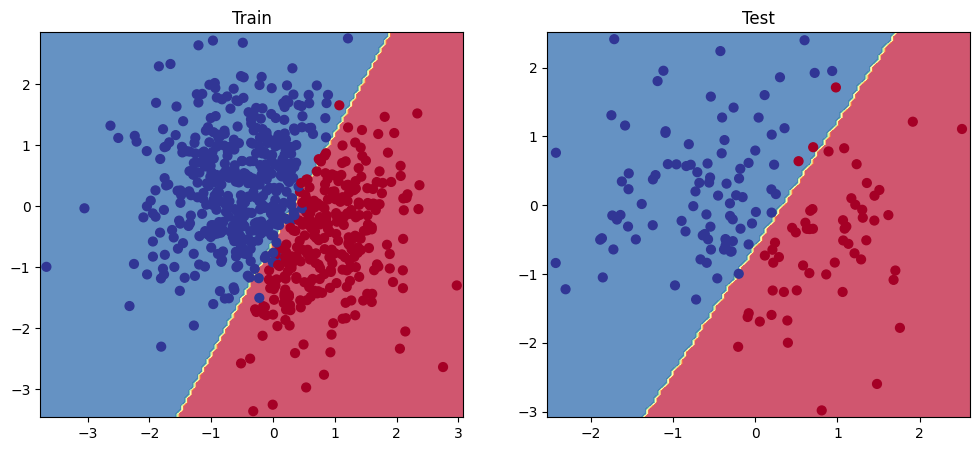

In [43]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train_scaled, y=y_train_enc)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test_scaled, y=y_test_enc)
plt.show()


### Pytorch Implementation

In [44]:
import torch

In [45]:
torch.manual_seed(seed = SEED)

In [46]:
# Pytorch linear layer
from torch import nn
import torch.nn.functional as F

In [47]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in)
        return z

In [48]:
# Initialize model
model = LogisticRegression(input_dim=input_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of LogisticRegression(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


### Loss
Crossentropy loss

In [49]:
loss_fn = nn.CrossEntropyLoss()
y_pred = torch.randn(3, num_classes, requires_grad=False)
y_true = torch.empty(3, dtype=torch.long).random_(num_classes)
print(y_pred)
print (y_true)
loss = loss_fn(y_pred, y_true)
print(f"Loss: {loss.numpy()}")


tensor([[-0.8545,  0.5098],
        [-0.0821,  0.6607],
        [ 0.0785,  0.7884]])
tensor([0, 0, 0])
Loss: 1.2779091596603394


In [50]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())) # Include class weights in loss function to counter class imbalance
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

### Metrics
Accuracy

In [51]:
def accuracy_fn(y_pred, y_true):
  n_correct = torch.eq(y_pred, y_true).sum().item() # Number of correct predictions. item() converts to scalar
  acc = (n_correct/len(y_pred)) * 100
  return acc

In [52]:
# Test
y_pred = torch.Tensor([0, 0, 1])
y_true = torch.Tensor([1, 0, 1])
print(f"Accuracy: {accuracy_fn(y_pred, y_true):.1f}")

Accuracy: 66.7


### Optimizer
Adam

In [53]:
from torch.optim import Adam

In [54]:
#instance of optimizer
optimizer = Adam(model.parameters(), lr=lr)

### Training
* Convert data to tensors
* Forward pass
* Compute loss
* Zero all gradients
* Backward pass
* Update weights

In [55]:
# Convert data to tensors
X_train_t = torch.Tensor(X_train_scaled)
y_train_t = torch.LongTensor(y_train_enc)
X_val_t = torch.Tensor(X_val_scaled)
y_val_t = torch.LongTensor(y_val_enc)
X_test_t = torch.Tensor(X_test_scaled)
y_test_t = torch.LongTensor(y_test_enc)


In [56]:
for epoch in range(epochs):
  # Forward pass
  y_pred = model(X_train_t)

  #compute loss
  loss = loss_fn(y_pred, y_train_t)

  # Zero all gradients
  optimizer.zero_grad()

  #Backward pass
  loss.backward()

  # Update weights
  optimizer.step()

  if epoch%5==0:
    predictions = y_pred.max(dim=1)[1] # class
    accuracy = accuracy_fn(y_pred=predictions, y_true=y_train_t)
    print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.96, accuracy: 60.7
Epoch: 5 | loss: 0.39, accuracy: 85.6
Epoch: 10 | loss: 0.28, accuracy: 87.0
Epoch: 15 | loss: 0.20, accuracy: 91.3
Epoch: 20 | loss: 0.15, accuracy: 95.6
Epoch: 25 | loss: 0.13, accuracy: 97.3
Epoch: 30 | loss: 0.12, accuracy: 97.7
Epoch: 35 | loss: 0.11, accuracy: 97.9
Epoch: 40 | loss: 0.10, accuracy: 98.3
Epoch: 45 | loss: 0.09, accuracy: 98.0


### Evaluation

#### Accuracy

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
torch.tensor([2, 4]).min(dim = 0)[1]

tensor(0)

In [59]:
# Predict y values in probability (Softmax)
pred_train = F.softmax(model(X_train_t), dim = 1)
pred_test = F.softmax(model(X_test_t), dim = 1)
print(f"Sample probability: {pred_test[1]}") # Print probabilities before converting to class values using the max function

pred_train = pred_train.max(dim = 1)[1] # The max() function returns a tuple containing the maximum values and their corresponding indices along the specified dimension 
pred_test = pred_test.max(dim = 1)[1] # (dim=1 representing the classes). [1] is used to access the indices, which represent the predicted classes.
print(f"Sample class: {pred_test[1]}")


Sample probability: tensor([9.9989e-01, 1.0652e-04], grad_fn=<SelectBackward0>)
Sample class: 0


In [60]:
pred_test

tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1])

In [61]:
# Accuracy score
train_accuracy = accuracy_score(y_train_t, pred_train)
test_accuracy = accuracy_score(y_test_t, pred_test)

print(f"Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}")

Train accuracy: 0.9771428571428571
Test accuracy: 0.98


#### precision_recall_fscore_support

In [62]:
from sklearn.metrics import precision_recall_fscore_support

In [63]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


In [64]:
# # Performance
performance = get_metrics(y_true=y_test_t, y_pred=pred_test, classes=label_encoder.classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9800264101112998,
    "recall": 0.98,
    "f1": 0.9799670975323149,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 0.9824561403508771,
      "recall": 0.9655172413793104,
      "f1": 0.9739130434782608,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.978494623655914,
      "recall": 0.9891304347826086,
      "f1": 0.9837837837837837,
      "num_samples": 92.0
    }
  }
}
